# DotA2 OpenData Processing
### -- Game Result Prediction with Heroes Picked  

Being one of the most famous RTS-styled (RTS: real-time strategy) MOBA-type (MOBA: multi-player online battle arena) competitive team game, DotA has been well-loved by its players all over the world for almost 20 year. It was established originally as a fan-developed custom mod "*Defense of the Ancients*" (DotA) of the *Warcraft III: The Frozen Throne* in 2003, and its first standalone installment in the series, Dota 2, was released by Valve in July 2013. In the game, two competing teams (*the Radiant* and *the Dire*) consist of five players each. Each player controls a single *Hero*, a strategically-powerful unit with unique abilities and characteristics which can be strengthened over the course of the game [[1]](https://dota2.fandom.com/wiki/Dota_2). 

This year, the DotA2 International 2021 (*TI10*) will be held from October 7th to 17th in Arena Națională in Bucharest, Romania. This project tries to do some basic data exploration and build a model to predict the results (the probability of winning of losing) given the heroes picked by two teams. 

Ideally, the heroes and characteristics in DotA2 are well-balanced (and the developers are trying to make them well-balanced), which means it is not likely that a certain hero combo would always win over others. However, we may also find something interesting in our analysis and modeling process.

In [1]:
import pandas as pd
import numpy as np
import datetime
import os
import json
import dota2
import collections
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import pickle

from timeit import default_timer as timer


## Data loading and exploration

Here we use a saved .csv file to load the data we extracted from dota2 API. The data extracting and saving process (and the codes) can be found in file *DotA2_OpenDataExtraction.ipynb*. 

In [2]:
# Read the json file for heroes and the dataset that we will use for analysis

df = pd.read_csv("match_df.csv")
print (df.shape)
df.head(10)

(62000, 16)


match_id  game_mode           start_time  duration  lobby_type  \
0  6101094500         22  2021-07-22 22:31:06       528           0   
1  6101094219         22  2021-07-22 22:31:02      1022           7   
2  6101090913         22  2021-07-22 22:26:27      1165           7   
3  6101090912          3  2021-07-22 22:26:27       952           7   
4  6101090506         22  2021-07-22 22:25:51      1378           7   
5  6101090019         22  2021-07-22 22:25:16      1221           7   
6  6101089808         22  2021-07-22 22:25:01      1179           7   
7  6101089604         22  2021-07-22 22:24:16      1286           7   
8  6101088516         22  2021-07-22 22:23:12      1450           7   
9  6101088204         22  2021-07-22 22:22:41      1353           7   

   radiant_1  radiant_2  radiant_3  radiant_4  radiant_5  dire_1  dire_2  \
0        135         32         94         20        104     128      10   
1         32        123         40          2         47      28      21   
2         45         18         61        123         20      74      26   
3        114         43         76         36        121      11     107   
4          8        112          2        123         99      11      19   
5         22         20        102         48          7      27      62   
6         18         47         78        101        104      13      26   
7         26         30         32         39         35      99       8   
8         17         19        121         12         88       8     128   
9         11         97         44          7          5      82      59   

   dire_3  dire_4  dire_5  radiant_win  
0      96      13      56         True  
1      46     103     114         True  
2      46      93      13         True  
3      14      63      41         True  
4      93     108     105         True  
5     119      75      94        False  
6      19      60      72         True  
7      87      74     104         True  
8      84      79      38         True  
9       2      91      53         True

In [3]:
pd.DataFrame(df['game_mode'].value_counts()).index

Int64Index([22, 3, 4, 5, 2], dtype='int64')

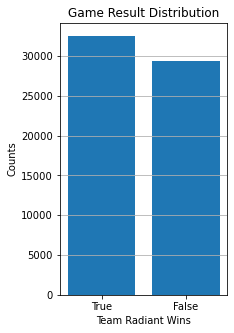

In [4]:
plt.figure(figsize = (3,5))
mode = [str(i) for i in pd.DataFrame(df['radiant_win'].value_counts()).index]
count = pd.DataFrame(df['radiant_win'].value_counts()).radiant_win
plt.bar(mode, count)
plt.title('Game Result Distribution')
plt.ylabel('Counts')
plt.xlabel('Team Radiant Wins')
plt.grid(axis='y', alpha=1)

In [5]:
print ("No. of games radiant wins:", df.radiant_win.sum())
print ("Total number of games:", df.shape[0])

No. of games radiant wins: 32545
Total number of games: 62000


#### Lobby_type and game_mode

In [6]:
# Check the game modes for all the matches. 
# The detailed information about different game modes can be found: https://github.com/odota/dotaconstants/blob/master/json/game_mode.json
# or here: http://sharonkuo.me/dota2/matchdetails.html

df.game_mode.value_counts()/df.shape[0]

22    0.911742
3     0.049097
4     0.036403
5     0.001790
2     0.000968
Name: game_mode, dtype: float64

Most of the matches (91.2%) have game mode `22: Ranked all pick`. There are also some games in mode `3: Random draft` or `4: Single draft`. Only a few have `5: All random` or `2: Captains mode`, and the latter `2: Captains mode` is a typical mode for professonal matches. 

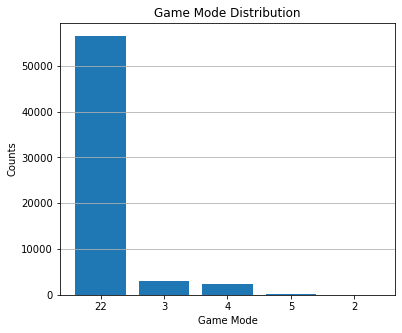

In [7]:
plt.figure(figsize = (6,5))
mode = [str(i) for i in pd.DataFrame(df['game_mode'].value_counts()).index]
count = pd.DataFrame(df['game_mode'].value_counts()).game_mode
plt.bar(mode, count)
plt.title('Game Mode Distribution')
plt.ylabel('Counts')
plt.xlabel('Game Mode')
plt.grid(axis='y', alpha=1)

In [8]:
# Check the lobby type for all the matches.
df.lobby_type.value_counts()/df.shape[0]

7    0.776726
0    0.222677
1    0.000597
Name: lobby_type, dtype: float64

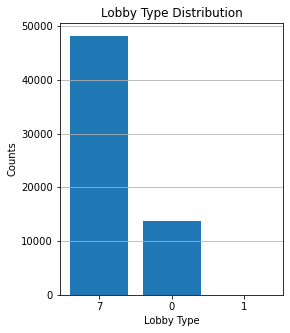

In [9]:
plt.figure(figsize = (4,5))
mode = [str(i) for i in pd.DataFrame(df['lobby_type'].value_counts()).index]
count = pd.DataFrame(df['lobby_type'].value_counts()).lobby_type
plt.bar(mode, count)
plt.title('Lobby Type Distribution')
plt.ylabel('Counts')
plt.xlabel('Lobby Type')
plt.grid(axis='y', alpha=1)

Checking the lobby_type of these matches, we could see that most of the matches are `0: Public matchmaking` and `7: Ranked`. Only 37 among all 62000 games are `1: Practice`, and we would remove them from our dataset. 

In [10]:
# Remove practice matches
df = df[df['lobby_type'] != 1]

In [11]:
# Check the start time for all games. We could see that the games are all in one day from 2021-07-22 05:53:46 to 2021-07-22 22:31:06
df.sort_values(by = ['start_time'])

match_id  game_mode           start_time  duration  lobby_type  \
61989  6100132217         22  2021-07-22 05:53:46      2573           0   
61997  6100132113         22  2021-07-22 05:53:55      2837           7   
61995  6100132115         22  2021-07-22 05:53:56      2657           7   
61999  6100132111         22  2021-07-22 05:54:00      1831           7   
61979  6100132412         22  2021-07-22 05:54:01      3099           7   
...           ...        ...                  ...       ...         ...   
4      6101090506         22  2021-07-22 22:25:51      1378           7   
3      6101090912          3  2021-07-22 22:26:27       952           7   
2      6101090913         22  2021-07-22 22:26:27      1165           7   
1      6101094219         22  2021-07-22 22:31:02      1022           7   
0      6101094500         22  2021-07-22 22:31:06       528           0   

       radiant_1  radiant_2  radiant_3  radiant_4  radiant_5  dire_1  dire_2  \
61989          1         20         47         21        121     106      44   
61997         74         71         17         62        104      36      87   
61995         21         83        101          2         48      42      74   
61999        128        104         27         31         44     135     123   
61979         25         69        105         76         48     111     102   
...          ...        ...        ...        ...        ...     ...     ...   
4              8        112          2        123         99      11      19   
3            114         43         76         36        121      11     107   
2             45         18         61        123         20      74      26   
1             32        123         40          2         47      28      21   
0            135         32         94         20        104     128      10   

       dire_3  dire_4  dire_5  radiant_win  
61989       3      75      82        False  
61997      94      33     123         True  
61995      29      14      79         True  
61999      13      48     112        False  
61979      67      74      14        False  
...       ...     ...     ...          ...  
4          93     108     105         True  
3          14      63      41         True  
2          46      93      13         True  
1          46     103     114         True  
0          96      13      56         True  

[61963 rows x 16 columns]

#### Match durations

We then take a look at the duration of these matches. 

count    61963.000000
mean        39.903894
std          9.660781
min          6.150000
25%         33.433333
50%         38.950000
75%         45.200000
max        135.233333
Name: duration, dtype: float64


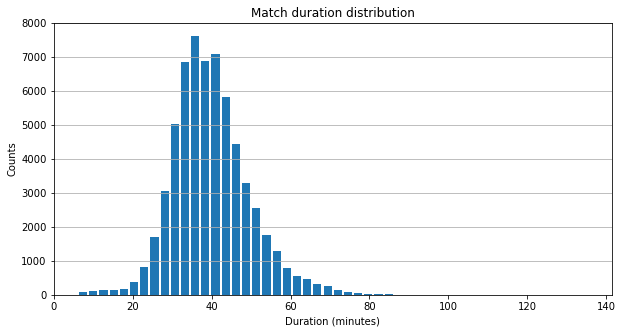

In [12]:
print ((df['duration']/60).describe())

plt.figure(figsize = (10,5))
plt.hist(df['duration']/60, bins=50, rwidth=0.8)
plt.title('Match duration distribution')
plt.ylabel('Counts')
plt.xlabel('Duration (minutes)')
plt.grid(axis='y', alpha=1)

We could see that most of the matches may last around 40 minutes. Some matches could last for more than two hours, while some others can also end very quickly.  
To guarantee the quality of the matches, we remove matches that are shorter than 15 minutes (900 seconds). 

In [13]:
df = df[df['duration'] >= 900].reset_index(drop = True)
print ((df['duration']/60).describe())

count    61602.000000
mean        40.072043
std          9.433548
min         15.000000
25%         33.533333
50%         39.000000
75%         45.250000
max        135.233333
Name: duration, dtype: float64


#### Heroes

In [14]:
heroes = []
for i in df[['radiant_1', 'radiant_2', 'radiant_3', 'radiant_4', 'radiant_5', 'dire_1', 'dire_2', 'dire_3', 'dire_4', 'dire_5']]:
    heroes.extend(df[i])

counter=collections.Counter(heroes)
print ("Number of heroes ever appeared in the dataset:", len(dict(counter).keys()))
{k: v for k, v in sorted(dict(counter).items(), key=lambda item: item[1], reverse=True)}.keys()

Number of heroes ever appeared in the dataset: 121


dict_keys([14, 26, 74, 8, 84, 2, 21, 48, 25, 44, 35, 9, 11, 30, 123, 99, 27, 112, 104, 6, 93, 86, 41, 68, 67, 1, 5, 42, 47, 22, 94, 46, 70, 75, 16, 105, 50, 49, 129, 13, 121, 71, 114, 12, 7, 101, 17, 29, 10, 98, 32, 87, 97, 119, 54, 62, 34, 40, 64, 88, 39, 23, 28, 81, 31, 36, 106, 72, 20, 63, 128, 83, 96, 76, 19, 59, 120, 18, 102, 109, 69, 53, 135, 4, 33, 100, 37, 126, 85, 51, 108, 56, 90, 15, 45, 110, 113, 52, 95, 111, 73, 107, 55, 58, 60, 79, 57, 43, 61, 3, 82, 89, 91, 103, 65, 78, 80, 38, 77, 92, 66])

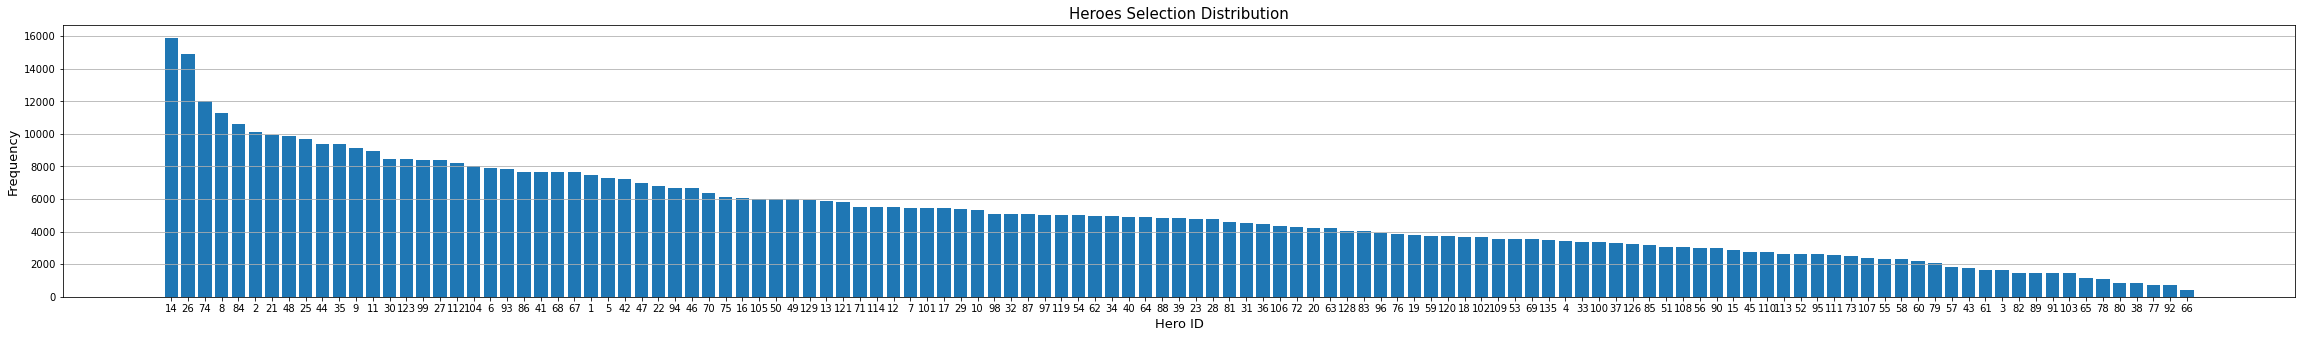

In [15]:
plt.figure(figsize = (40,5))
heroes = pd.DataFrame(sorted(dict(counter).items())).sort_values(by = [1], ascending = False).rename(columns = {0: "hero_id", 1: "count"}).reset_index(drop = True)
mode = [str(i) for i in heroes['hero_id']]
count = heroes['count']
plt.bar(mode, count)
plt.title('Heroes Selection Distribution', fontsize=15)
plt.ylabel('Frequency', fontsize=13)
plt.xlabel('Hero ID', fontsize=13)
plt.grid(axis='y', alpha=1)


In [16]:
df.iloc[0]

match_id                6101094219
game_mode                       22
start_time     2021-07-22 22:31:02
duration                      1022
lobby_type                       7
radiant_1                       32
radiant_2                      123
radiant_3                       40
radiant_4                        2
radiant_5                       47
dire_1                          28
dire_2                          21
dire_3                          46
dire_4                         103
dire_5                         114
radiant_win                   True
Name: 0, dtype: object

In [17]:
# The following functions are used to extract heroes' information from hero.json file obtained from Dota2 OpenData.
# We then could take a closer look at the rank. 

with open('heroes.json') as f:
    hero = json.load(f)
hero = pd.DataFrame(hero) 

def getHeroName(hero_id):
    '''
    A function used to get a hero's name from the hero's id.
    
    INPUT:
    - hero_id: the hero's id (integer)
    
    OUTPUT:
    - name: the hero's name (string)
    '''    
    
    name = hero[hero['id'] == hero_id]['localized_name'].item() # replace the number to get more information of a hero
    return name

def getHeroRoles(hero_id):
    '''
    A function used to get a hero's roles from the hero's id.
    
    INPUT:
    - hero_id: the hero's id (integer)
    
    OUTPUT:
    - roles: the hero's roles (list)
    '''    
    
    roles = hero[hero['id'] == hero_id]['roles'].item() # replace the number to get more information of a hero
    return roles

def getHeroAttr(hero_id):
    '''
    A function used to get a hero's primary attribute (strength - 'str', agility - 'agi', or intelligence - 'int') from the hero's id.
    
    INPUT:
    - hero_id: the hero's id (integer)
    
    OUTPUT:
    - attr: the hero's primary attribute (string)
    '''    
    
    attr = hero[hero['id'] == hero_id]['primary_attr'].item() # replace the number to get more information of a hero
    return attr


getHeroName(66)

'Chen'

With these functions and the results, we could see that all the 121 heroes appear in our dataset.  
- Top 5 MOST frequently picked heroes: *Pudge* (No. 14), *Lion* (No. 26), *Invoker* (No. 74), *Juggernaut* (No. 8), *Ogre Magi* (No. 84)  
- Top 5 LEAST frequently picked heroes: *Chen* (No. 66), *Visage* (No. 92), *Lycan* (No. 77), *Beastmaster* (No. 38), and *Lone Druid* (No. 80)  

One funny thing is that among the 5 MOST frequently picked heroes, *Pudge* and *Ogre Magi* are two heroes that are not popular in professional matches. This can be observed if you further take a look at the heroStats.json file data, which includes hero statistics in recent professional matches. 

## Data processing

We then consider adding more features for each team. Since the heroes also have their primary attributes, attack types, and roles they could play, more features are added to our dataset.

We first add features related to hero primary attribute. Hero Attributes are aspects of *Strength*, *Agility*, and *Intelligence* found in all heroes, and each hero has a primary aspect called Primart Attribute. For each match, we consider the number of heroes with different primary attribute in each team.  

For example, in the match with match_id of 6101094219, the radiant team picked 1 hero of *Strength*, 3 heroes of *Agility*, and 1 hero of *Intelligence*, while the dire team picked 0 *Strength* hero, 2 *Agility* heroes, and 3 *Intelligence* heroes.  

Six new columns are added to dataset df: 'radiant_str', 'radiant_agi', 'radiant_int', 'dire_str', 'dire_agi', 'dire_int'

In [18]:
# Heroes primary attribute combination for each team

def addPAColumns(df):
    '''
    A function adding columns for number of heroes with different primary attribute (PA) to df.
    
    INPUT:
    - df: dataset of match data with radiant's and dire team's hero selection
    
    OUTPUT:
    - df: dataset with 6 more columns: 'rad_str', 'rad_agi', 'rad_int', 'dir_str', 'dir_agi', 'dir_int'
    '''
    
    attr_dic = {"rad_str": [], "rad_agi": [], "rad_int": [], 
           "dir_str": [], "dir_agi": [], "dir_int": []}

    rad1_loc = df.columns.get_loc('radiant_1')
    dir1_loc = df.columns.get_loc('dire_1')
    for i in range(df.shape[0]):
        # team radiant
        rad_list = list(map(getHeroAttr, df.iloc[i, rad1_loc:(rad1_loc + 5)].to_list()))
        attr_dic['rad_str'].append(rad_list.count('str'))
        attr_dic['rad_agi'].append(rad_list.count('agi'))
        attr_dic['rad_int'].append(rad_list.count('int'))
        # team dire
        dir_list = list(map(getHeroAttr, df.iloc[i, dir1_loc:(dir1_loc + 5)].to_list()))
        attr_dic['dir_str'].append(dir_list.count('str'))
        attr_dic['dir_agi'].append(dir_list.count('agi'))
        attr_dic['dir_int'].append(dir_list.count('int'))

    attr_dic = pd.DataFrame(attr_dic)
    df[['rad_str', 'rad_agi', 'rad_int', 'dir_str', 'dir_agi', 'dir_int']] = attr_dic
    return df

df = addPAColumns(df)
df.head()

match_id  game_mode           start_time  duration  lobby_type  \
0  6101094219         22  2021-07-22 22:31:02      1022           7   
1  6101090913         22  2021-07-22 22:26:27      1165           7   
2  6101090912          3  2021-07-22 22:26:27       952           7   
3  6101090506         22  2021-07-22 22:25:51      1378           7   
4  6101090019         22  2021-07-22 22:25:16      1221           7   

   radiant_1  radiant_2  radiant_3  radiant_4  radiant_5  ...  dire_3  dire_4  \
0         32        123         40          2         47  ...      46     103   
1         45         18         61        123         20  ...      46      93   
2        114         43         76         36        121  ...      14      63   
3          8        112          2        123         99  ...      93     108   
4         22         20        102         48          7  ...     119      75   

   dire_5  radiant_win  rad_str  rad_agi  rad_int  dir_str  dir_agi  dir_int  
0     114         True        1        4        0        2        2        1  
1      13         True        1        3        1        0        2        3  
2      41         True        0        1        4        2        3        0  
3     105         True        2        2        1        2        2        1  
4      94        False        2        2        1        0        2        3  

[5 rows x 22 columns]

In [19]:
df[['match_id', 'rad_str', 'rad_agi', 'rad_int', 'dir_str', 'dir_agi', 'dir_int']].head(10)

match_id  rad_str  rad_agi  rad_int  dir_str  dir_agi  dir_int
0  6101094219        1        4        0        2        2        1
1  6101090913        1        3        1        0        2        3
2  6101090912        0        1        4        2        3        0
3  6101090506        2        2        1        2        2        1
4  6101090019        2        2        1        0        2        3
5  6101089808        3        1        1        2        1        2
6  6101089604        0        2        3        2        1        2
7  6101088516        1        2        2        2        1        2
8  6101088204        2        2        1        3        1        1
9  6101088010        2        2        1        1        2        2

Consider adding features related to hero roles in the dataset. In total there are 9 possible roles for all heroes: *Carry*, *Disabler*, *Durable*, *Escape*, *Initiator*, *Jungler*, *Nuker*, *Pusher*, *Support*. Each hero could have more than one role. Since the match dataset does not tell which role a hero actually takes in a match, in this project, I only considered how many selected heroes could take each role in a team.  

For example, in match with match_id 6101094219, the radiant team selected heroes 32, 123, 40, 2, and 47. Referring to hero_df, for each hero, we could get a list of 0-1 values indicating which roles among all 9 roles this hero could play:  

Hero 32: $[1, 1, 0, 1, 0, 0, 0, 0, 0]$  
Hero 123: $[0, 1, 0, 1, 0, 0, 1, 0, 0]$  
Hero 40: $[0, 1, 0, 0, 1, 0, 1, 1, 1]$  
Hero 2: $[1, 1, 1, 0, 1, 1, 0, 0, 0]$  
Hero 47: $[1, 1, 1, 0, 1, 0, 0, 0, 0]$  

With these five 9-digit lists, we could generate a overall 9-digit list, by summing up the five lists by column, i.e., summing up the five numbers from the five lists for each role. In this example, we would obtain:  

radiant = $[3, 5, 2, 2, 3, 1, 2, 1, 1]$  
Similarly, for dire team, we would obtain:
dire = $[4, 4, 2, 4, 3, 0, 2, 0, 1]$  

As a whole, for match number 6101094219, we would have a 18-digit list for the role attributes. We want to add these columns to our dataset.

In [20]:
# Generate a dataframe of heroes with roles as dummy variables

def getHeroDF(hero):
    '''
    A function used to generate a dummy-value dataframe of heroes. Each row is a hero and each column is a role. 
    The 0-1 values in the dataframe indicates whether a hero (row) could play a role (column).
    
    INPUT:
    - hero: the hero dataframe
    
    OUTPUT:
    - hero_df: the dummy-value dataframe for heroes
    
    '''

    hero = hero.set_index('id')

    hero_df = pd.DataFrame(hero['roles'].to_list())
    hero_df['id'] = hero.index
    hero_df = hero_df.set_index('id')

    hero_df = pd.get_dummies(hero_df.stack()).groupby(level=0).sum()
    return hero_df

hero_df = getHeroDF(hero)
hero_df.head(10)

Carry  Disabler  Durable  Escape  Initiator  Jungler  Nuker  Pusher  \
id                                                                        
1       1         0        0       1          0        0      1       0   
2       1         1        1       0          1        1      0       0   
3       0         1        1       0          0        0      1       0   
4       1         1        0       0          1        1      1       0   
5       0         1        0       0          0        1      1       0   
6       1         1        0       0          0        0      0       1   
7       0         1        0       0          1        0      1       0   
8       1         0        0       1          0        0      0       1   
9       1         1        0       1          0        0      1       0   
10      1         1        1       1          0        0      1       0   

    Support  
id           
1         0  
2         0  
3         1  
4         0  
5         1  
6         0  
7         1  
8         0  
9         1  
10        0

With this hero_df dataframe, we are now able to evaluate whether the heroes a team picked has covered all roles, or which role (or roles) the heroes misses. We then add 18 columns ( $9 \times 2 = 18$, for two teams) correspondingly. 

In [21]:
# Now add columns for hero roles into our dataset

def getHeroRoleSum(df, hero_df):
    '''
    A function used to add hero role columns in df dataframe. The role columns indicate how many heroes can play this role in a team.
    
    INPUT:
    - df: match dataframe df
    - hero_df: a dataframe of heroes of hero roles
    
    OUTPUT:
    - df: dataframe df with 18 new columns
    '''
    
    radiant_roles, dire_roles = [], []
    for i in range(df.shape[0]):
        radiant_roles.append(hero_df[hero_df.index.isin(df.iloc[i, 5:10].to_list())].sum())
        dire_roles.append(hero_df[hero_df.index.isin(df.iloc[i, 10:15].to_list())].sum())

    radiant_roles = pd.DataFrame(radiant_roles).rename(columns = {0: 'rad_carry', 1: 'rad_disabler', 2: 'rad_durable', 3:'rad_escape', 4: 'rad_initiator', 
                                           5: 'rad_jungler', 6: 'rad_nuker', 7: 'rad_pusher', 8: 'rad_support'})
    dir_roles = pd.DataFrame(dire_roles).rename(columns = {0: 'dir_carry', 1: 'dir_disabler', 2: 'dir_durable', 3:'dir_escape', 4: 'dir_initiator', 
                                           5: 'dir_jungler', 6: 'dir_nuker', 7: 'dir_pusher', 8: 'dir_support'})
    df[['rad_carry', 'rad_disabler', 'rad_durable', 'rad_escape', 'rad_initiator', 'rad_jungler', 'rad_nuker', 'rad_pusher', 'rad_support']] = radiant_roles
    df[['dir_carry', 'dir_disabler', 'dir_durable', 'dir_escape', 'dir_initiator', 'dir_jungler', 'dir_nuker', 'dir_pusher', 'dir_support']] = dire_roles
    return df


def addHeroRoleColumns(df, hero_df):
    '''
    A function used to add hero role columns in df dataframe. The role columns indicate whether a team selects a hero who can play this role.
    
    INPUT:
    - df: match dataframe df
    - hero_df: a dataframe of heroes with roles as dummy variables, indicating whether the hero could play the role
    
    OUTPUT:
    - df: dataframe df with 18 new columns
    '''
    
    radiant_roles, dire_roles = [], []
    for i in range(df.shape[0]):
        radiant_roles.append(list(map(lambda x: 1 if x > 0 else 0, hero_df[hero_df.index.isin(df.iloc[i, 5:10].to_list())].sum())))
        dire_roles.append(list(map(lambda x: 1 if x > 0 else 0, hero_df[hero_df.index.isin(df.iloc[i, 10:15].to_list())].sum())))

    radiant_roles = pd.DataFrame(radiant_roles).rename(columns = {0: 'rad_carry', 1: 'rad_disabler', 2: 'rad_durable', 3:'rad_escape', 4: 'rad_initiator', 
                                           5: 'rad_jungler', 6: 'rad_nuker', 7: 'rad_pusher', 8: 'rad_support'})
    dir_roles = pd.DataFrame(dire_roles).rename(columns = {0: 'dir_carry', 1: 'dir_disabler', 2: 'dir_durable', 3:'dir_escape', 4: 'dir_initiator', 
                                           5: 'dir_jungler', 6: 'dir_nuker', 7: 'dir_pusher', 8: 'dir_support'})
    df[['rad_carry', 'rad_disabler', 'rad_durable', 'rad_escape', 'rad_initiator', 'rad_jungler', 'rad_nuker', 'rad_pusher', 'rad_support']] = radiant_roles
    df[['dir_carry', 'dir_disabler', 'dir_durable', 'dir_escape', 'dir_initiator', 'dir_jungler', 'dir_nuker', 'dir_pusher', 'dir_support']] = dire_roles
    return df


In [22]:
df = getHeroRoleSum(df, hero_df)
df.head()

match_id  game_mode           start_time  duration  lobby_type  \
0  6101094219         22  2021-07-22 22:31:02      1022           7   
1  6101090913         22  2021-07-22 22:26:27      1165           7   
2  6101090912          3  2021-07-22 22:26:27       952           7   
3  6101090506         22  2021-07-22 22:25:51      1378           7   
4  6101090019         22  2021-07-22 22:25:16      1221           7   

   radiant_1  radiant_2  radiant_3  radiant_4  radiant_5  ...  rad_support  \
0         32        123         40          2         47  ...            1   
1         45         18         61        123         20  ...            1   
2        114         43         76         36        121  ...            1   
3          8        112          2        123         99  ...            1   
4         22         20        102         48          7  ...            3   

   dir_carry  dir_disabler  dir_durable  dir_escape  dir_initiator  \
0          4             4            2           4              3   
1          3             4            0           4              2   
2          3             3            3           3              3   
3          3             4            2           2              1   
4          2             4            1           2              2   

   dir_jungler  dir_nuker  dir_pusher  dir_support  
0            0          2           0            1  
1            0          4           1            1  
2            0          3           0            0  
3            0          5           1            1  
4            0          4           1            3  

[5 rows x 40 columns]

In [23]:
# Take a look at these role variables in the dataset
df[['match_id', 'rad_carry', 'rad_disabler', 'rad_durable', 'rad_escape', 'rad_initiator', 'rad_jungler', 'rad_nuker', 'rad_pusher', 'rad_support',
   'dir_carry', 'dir_disabler', 'dir_durable', 'dir_escape', 'dir_initiator', 'dir_jungler', 'dir_nuker', 'dir_pusher', 'dir_support']].head(10)

match_id  rad_carry  rad_disabler  rad_durable  rad_escape  \
0  6101094219          3             5            2           2   
1  6101090913          2             3            1           3   
2  6101090912          4             5            1           2   
3  6101090506          3             3            2           2   
4  6101090019          3             2            1           1   
5  6101089808          4             5            4           0   
6  6101089604          3             3            0           2   
7  6101088516          3             4            1           4   
8  6101088204          2             3            0           2   
9  6101088010          3             5            3           3   

   rad_initiator  rad_jungler  rad_nuker  rad_pusher  rad_support  dir_carry  \
0              3            1          2           1            1          4   
1              2            0          5           2            1          3   
2              1            0          4           1            1          3   
3              2            1          3           1            1          3   
4              2            0          4           1            3          2   
5              4            0          4           0            1          3   
6              1            0          4           0            2          4   
7              3            0          5           2            1          1   
8              2            1          4           0            2          4   
9              3            0          4           1            1          4   

   dir_disabler  dir_durable  dir_escape  dir_initiator  dir_jungler  \
0             4            2           4              3            0   
1             4            0           4              2            0   
2             3            3           3              3            0   
3             4            2           2              1            0   
4             4            1           2              2            0   
5             5            2           1              4            0   
6             3            2           2              3            0   
7             4            2           2              3            0   
8             2            2           3              3            2   
9             4            1           2              1            0   

   dir_nuker  dir_pusher  dir_support  
0          2           0            1  
1          4           1            1  
2          3           0            0  
3          5           1            1  
4          4           1            3  
5          5           1            1  
6          4           2            1  
7          4           1            3  
8          3           2            1  
9          4           0            2

There are 121 different heroes available for each team (some heroes would indeed be banned in professional matches, but I assume that these won't impact our model here), and each hero can only be selected once in a match. In other words, assume that one player in the radiant team selects Hero Axe (No. 2 in the hero data frame) in a match. Whether in team radiant or team dire, other players can not choose this hero "Axe" again in this match.  

We add 121 features representing the 121 heroes for each team (in total, there would be 242 features). The features are named in a format of "rad_xxx" or "dir_xxx," where the "xxx" represents the hero ids. For each row, i.e., each match, the heroes picked by the two teams would have value "1" while others would be "0". In other words, for each match, there would be ten "1"s in these features.  

Let me use a match (match_id = "6101094219") as an example. The team Radiant picked heroes 32, 123, 40, 2, and 47. In this row, columns "rad_32," "rad_123," "rad_40," "rad_2," and "rad_47" will be assigned value "1," while all other columns "rad_xxx" will be 0. Meanwhile, team Dire picked heroes 28, 21, 46, 103, and 144. Thus, in the same row, columns "dir_28,” "dir_21,” "dir_46,” "dir_103," and "dir_144," will be assigned value "1." Other "rad_xxx" or "dir_xxx" columns would be “0.”


In [24]:
rad_picks = pd.get_dummies(df[['radiant_1', 'radiant_2', 'radiant_3', 'radiant_4', 'radiant_5']].stack(), prefix='rad').groupby(level=0).sum()
dir_picks = pd.get_dummies(df[['dire_1', 'dire_2', 'dire_3', 'dire_4', 'dire_5']].stack(), prefix='dir').groupby(level=0).sum()
df = pd.concat([df, rad_picks, dir_picks], axis = 1)
df

match_id  game_mode           start_time  duration  lobby_type  \
0      6101094219         22  2021-07-22 22:31:02      1022           7   
1      6101090913         22  2021-07-22 22:26:27      1165           7   
2      6101090912          3  2021-07-22 22:26:27       952           7   
3      6101090506         22  2021-07-22 22:25:51      1378           7   
4      6101090019         22  2021-07-22 22:25:16      1221           7   
...           ...        ...                  ...       ...         ...   
61597  6100132115         22  2021-07-22 05:53:56      2657           7   
61598  6100132114         22  2021-07-22 05:54:05      3415           0   
61599  6100132113         22  2021-07-22 05:53:55      2837           7   
61600  6100132112         22  2021-07-22 05:54:04      2469           7   
61601  6100132111         22  2021-07-22 05:54:00      1831           7   

       radiant_1  radiant_2  radiant_3  radiant_4  radiant_5  ...  dir_113  \
0             32        123         40          2         47  ...        0   
1             45         18         61        123         20  ...        0   
2            114         43         76         36        121  ...        0   
3              8        112          2        123         99  ...        0   
4             22         20        102         48          7  ...        0   
...          ...        ...        ...        ...        ...  ...      ...   
61597         21         83        101          2         48  ...        0   
61598         44        105          2         34          9  ...        0   
61599         74         71         17         62        104  ...        0   
61600          8          2         44         12         75  ...        0   
61601        128        104         27         31         44  ...        0   

       dir_114  dir_119  dir_120  dir_121  dir_123  dir_126  dir_128  dir_129  \
0            1        0        0        0        0        0        0        0   
1            0        0        0        0        0        0        0        0   
2            0        0        0        0        0        0        0        0   
3            0        0        0        0        0        0        0        0   
4            0        1        0        0        0        0        0        0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
61597        0        0        0        0        0        0        0        0   
61598        0        0        0        0        0        0        0        0   
61599        0        0        0        0        1        0        0        0   
61600        0        0        0        1        1        0        0        0   
61601        0        0        0        0        1        0        0        0   

       dir_135  
0            0  
1            0  
2            0  
3            0  
4            0  
...        ...  
61597        0  
61598        0  
61599        0  
61600        0  
61601        1  

[61602 rows x 282 columns]

### Modeling  

In this project, I use Light Gradient Boosting Model (LGBM) to train and predict the game results. 
 
The dataset is firstly split into a training set (80% of the data) and a testing set (20% of the data). I use the training set to train the model (with cross-validation), and the test set to test the performance of the trained model. 

In [25]:
# Define X and Y
# Split the dataset into training and testing sets

X = df.drop(columns = ['match_id', 'game_mode', 'start_time', 'lobby_type', 'radiant_win', 
                       'radiant_1', 'radiant_2', 'radiant_3', 'radiant_4', 'radiant_5', 'dire_1', 'dire_2', 'dire_3', 'dire_4', 'dire_5'])
Y = df.radiant_win
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [33]:
# Develop the LGBM pipeline, and train the model

def model_LGBM():
    pipeline_LGBM = Pipeline([
        ('lgbm', lgb.LGBMClassifier(random_state = 0, n_estimators = 100, max_bin = 200))
    ])
    
    parameters = {
        'lgbm__max_depth': [2, 3, 5],
        'lgbm__min_data_in_leaf': [30, 40, 50],
        'lgbm__learning_rate': [0.4, 0.5, 0.6],
        'lgbm__num_leaves': [50, 100],
        'lgbm__bagging_fraction': [0.7, 0.8, 0.9],
        'lgbm__feature_fraction': [0.4, 0.45, 0.5],
        'lgbm__bagging_freq': [5, 10, 20],       
        'lgbm__lambda_l2': [5, 10],
        }

    cv = GridSearchCV(pipeline_LGBM, param_grid = parameters)
    return cv

lgbm = model_LGBM()
lgbm.fit(X_train, y_train)

pickle_out = open("lgbm.pkl", 'wb')
pickle.dump(lgbm, pickle_out)
pickle_out.close()


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ig

GridSearchCV(estimator=Pipeline(steps=[('lgbm',
                                        LGBMClassifier(max_bin=200,
                                                       random_state=0))]),
             param_grid={'lgbm__bagging_fraction': [0.7, 0.8, 0.9],
                         'lgbm__bagging_freq': [5, 10, 20],
                         'lgbm__feature_fraction': [0.4, 0.45, 0.5],
                         'lgbm__lambda_l2': [5, 10],
                         'lgbm__learning_rate': [0.4, 0.5, 0.6],
                         'lgbm__max_depth': [2, 3, 5],
                         'lgbm__min_data_in_leaf': [30, 40, 50],
                         'lgbm__num_leaves': [50, 100]})

In [36]:
pickle_in = open('lgbm.pkl', 'rb')
lgbm = pickle.load(pickle_in)

prediction = lgbm.predict(X_train)
print ("Training Accuracy:", accuracy_score(y_train, prediction))
print ("Training AUC:", roc_auc_score(y_train, lgbm.predict_proba(X_train)[:, 1]))

prediction = lgbm.predict(X_test)
print ("Testing Accuracy:", accuracy_score(y_test, prediction))
print ("Testing AUC:", roc_auc_score(y_test, lgbm.predict_proba(X_test)[:, 1]))


Training Accuracy: 0.6452385300622958
Training AUC: 0.7007606358901872
Testing Accuracy: 0.5727619511403296
Testing AUC: 0.6034062295185945


As expected, the model performance is poor if I only using heroes selected to predict the game results. This is reasonable, since a game result should not be purely decided by what heroes the players use or how long the game lasts. However, the model may tell me some other information.  

I also took a look at the feature importance of the model. The following figure shows the distribution of the feature importance. It can be noticed that while most of the features have very low importance scores, some features do have higher importance than others. 

In [37]:
# Get model feature importance

df_importance = pd.DataFrame({'feature': X.columns, 'feature_importance': lgbm.feature_importances_})
df_importance = df_importance.sort_values(by = ['feature_importance'], ascending = False)

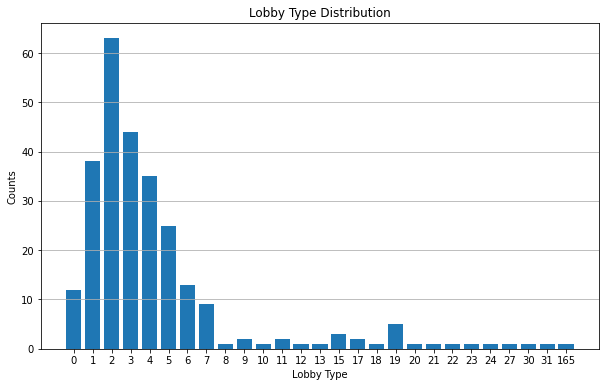

In [38]:
plt.figure(figsize = (10,6))
feature_imp = pd.DataFrame(df_importance.feature_importance.value_counts()).sort_index()
mode = [str(i) for i in feature_imp.index]
count = feature_imp['feature_importance']

plt.bar(mode, count)
plt.title('Lobby Type Distribution')
plt.ylabel('Counts')
plt.xlabel('Lobby Type')
plt.grid(axis='y', alpha=1)

Let’s see what features have importance no lower than 7 (>6). 

In [39]:
# Then I would take a look at the features that have importance higher than the threshold

threshold = 7
print ("Number of features with feature importance no smaller than {}:".format(threshold), 
       df_importance[df_importance['feature_importance'] >= threshold].shape[0])
df_importance[df_importance['feature_importance'] >= threshold]

Number of features with feature importance no smaller than 7: 37


feature  feature_importance
0         duration                 165
19      dir_escape                  31
13       rad_nuker                  30
7        rad_carry                  27
1          rad_str                  24
4          dir_str                  23
9      rad_durable                  22
12     rad_jungler                  21
11   rad_initiator                  20
15     rad_support                  19
16       dir_carry                  19
23      dir_pusher                  19
10      rad_escape                  19
14      rad_pusher                  19
2          rad_agi                  18
6          dir_int                  17
3          rad_int                  17
18     dir_durable                  15
20   dir_initiator                  15
22       dir_nuker                  15
8     rad_disabler                  13
25           rad_1                  12
17    dir_disabler                  11
21     dir_jungler                  11
5          dir_agi                  10
228         dir_84                   9
24     dir_support                   9
92          rad_69                   8
192         dir_48                   7
71          rad_48                   7
46          rad_22                   7
146          dir_1                   7
30           rad_6                   7
190         dir_46                   7
98          rad_75                   7
97          rad_74                   7
90          rad_67                   7

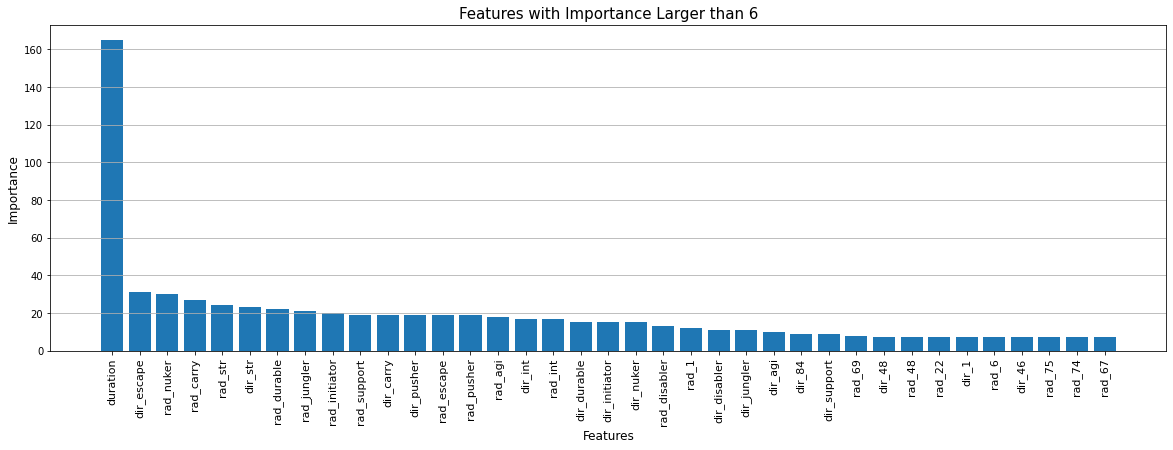

In [40]:
plt.figure(figsize = (20,6))
feature_imp = df_importance[df_importance['feature_importance'] >= threshold]
mode = [str(i) for i in feature_imp.feature]
count = feature_imp['feature_importance']

plt.bar(mode, count)
plt.title('Features with Importance Larger than 6', fontsize = 15)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Features', fontsize = 12)
plt.xticks(rotation='vertical', fontsize = 11)
plt.grid(axis='y', alpha=1)

In [41]:
# Check the heroes

print ('\n  Both teams:') 
for i in [1, 48]:
    print (getHeroName(i))

print ('\n  Single team:')
for i in [84, 69, 22, 6, 46, 75, 74, 67]:
    print (getHeroName(i))



  Both teams:
Anti-Mage
Luna

  Single team:
Ogre Magi
Doom
Zeus
Drow Ranger
Templar Assassin
Silencer
Invoker
Spectre


Among all features, “Duration” has the highest importance score (the importance is much higher than any other features, as shown in Figure 10). I would believe duration, as a feature that could interact and work together with all other features, may contribute the most to the predictive model.  

It can also be obviously noticed that almost all non-hero features (features related to primary attributes or roles)  have higher importance than hero features (features that are directly related to certain heroes). While there seems no observable importance difference for hero roles, the “Strength” primary attribute seems to have higher importance than other primary attributes. However, this does not mean that the number of strength heroes itself would impact the result of the game. The importance scores tell the predictive ability of variables in the model. It has no direct relationship with whether a single feature has a positive or negative effect on the result of the game, because the variables in the tree model all affect each other and play a role in the prediction.  But from the model I might feel that a balanced combination of roles or primary attributes would impact the game result more than certain heroes. 

In [42]:
# Check the winning rate for teams with Hero Luna

hero_no = 48
print ("Winning rate for Radiant Team with Hero {}: ".format(hero_no), df[df['rad_{}'.format(hero_no)] == 1]['radiant_win'].sum() / df[df['rad_{}'.format(hero_no)] == 1].shape[0])
print ("Winning rate for Dire Team with Hero {}: ".format(hero_no), 1 - df[df['dir_{}'.format(hero_no)] == 1]['radiant_win'].sum() / df[df['dir_{}'.format(hero_no)] == 1].shape[0])

print ("Winning rate for Radiant Team on average: ", df['radiant_win'].sum() / df.shape[0])
print ("Winning rate for Dire Team on average: ", 1 - df['radiant_win'].sum() / df.shape[0])


Winning rate for Radiant Team with Hero 48:  0.5627906976744186
Winning rate for Dire Team with Hero 48:  0.5177333876885446
Winning rate for Radiant Team on average:  0.524463491445083
Winning rate for Dire Team on average:  0.475536508554917
